ref: https://testdriven.io/blog/developing-an-asynchronous-task-queue-in-python/

In [2]:
from math import factorial
import numpy as np
import itertools
import multiprocessing
import numba
import time
import matplotlib.pyplot as plt

Exemplo: consome a lista em paralelo:

In [2]:
def f(x):
    for i in range(8_000): a = x**i  # burn the cpu
#     print(multiprocessing.current_process())
    return x + 1

def process(f, data):
    pool = multiprocessing.Pool(processes)
    for result in pool.imap_unordered(f, data):
        yield result
    pool.close()
    pool.join()


processes = multiprocessing.cpu_count()
data = list(range(100))

chunksize = 10
results = []
for result in process(f, data):
    results += [result]
print('data:   \t', data)
print('results:\t', results)

data:   	 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
results:	 [2, 1, 3, 4, 5, 9, 6, 7, 8, 13, 17, 10, 11, 12, 15, 16, 14, 18, 19, 21, 25, 22, 23, 24, 20, 33, 29, 26, 27, 28, 30, 32, 34, 35, 31, 41, 36, 39, 38, 37, 40, 45, 42, 44, 46, 43, 49, 48, 47, 50, 52, 51, 57, 54, 55, 53, 65, 58, 59, 56, 60, 61, 62, 64, 63, 66, 67, 68, 70, 69, 72, 73, 74, 71, 75, 77, 81, 76, 78, 80, 79, 82, 84, 83, 85, 89, 88, 86, 97, 90, 87, 93, 91, 92, 94, 95, 96, 98, 99, 100]


Exemplo: consome chunks de uma lista em paralelo:

In [3]:
def func_data(x):
    for i in range(8_000): a = x**i  # burn the cpu
    return x + 1

def func_chunk(arr):
    ret = []
    for a in arr:
        ret += [func_data(a)]
    return ret

def chunker(iterator, size):
    iterator = iter(iterator)
    while chunk := list(itertools.islice(iterator, size)):
        yield chunk

def process(f, data):
    pool = multiprocessing.Pool(processes)
    chunks = chunker(data, chunksize)
    for result in pool.imap_unordered(func_chunk, chunks):
        yield result
    pool.close()
    pool.join()


chunksize = 4
processes = multiprocessing.cpu_count()
data = list(range(chunksize * processes))

results = []
for result in process(f, data):
    results += [*result]
print('data:   \t', data)
print('results:\t', results)

data:   	 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
results:	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 34, 35, 36, 41, 42, 43, 44, 29, 30, 31, 32, 49, 50, 51, 52, 37, 38, 39, 40, 61, 62, 63, 64, 53, 54, 55, 56, 45, 46, 47, 48, 57, 58, 59, 60]


Exemplo: consome chunks de uma itertools.permutations em paralelo

In [6]:
def func_data(arr):
    global B
#     return [arr[i]-B[i] for i in range(len(arr))]  # slower
    return np.array(arr).reshape((-1, len(B))) - B

def func_chunk(chunk):
#     return [func_data(data) for data in chunk]  # slower
    return np.apply_along_axis(func_data, 1, chunk)

def chunker(iterator, size):
    iterator = iter(iterator)
    while chunk := list(itertools.islice(iterator, size)):
        yield chunk

def parallel_process(f, data):
    pool = multiprocessing.Pool(processes)
    for result in pool.imap_unordered(f, data):
        yield result
    pool.close()
    pool.join()

def optimize(chunksize):
    results = []
    chunks_counter = 0
    
    chunks = chunker(permutations, chunksize)
    for result in parallel_process(func_chunk, chunks):
        results += [*result]
        chunks_counter += 1
    print("Chunks:", chunks_counter)
    
    results = np.array(results).reshape((-1, len(B)))
    
    return results

A = np.array(range(10))
B = np.array(range(10)) + 0.2
print('A:', A, '\nB:', B, '\n' + '-' * 80);

chunksize = 2**8
processes = multiprocessing.cpu_count() 

elapsed_time = -time.time()
permutations = itertools.permutations(A, len(B))
results = optimize(chunksize)
elapsed_time += time.time()
print("Chunk Size:", chunksize)
print("Data length:", results.size)
print("Elapsed Time:", elapsed_time, 's')
print("Results:\n", results)

A: [0 1 2 3 4 5 6 7 8 9] 
B: [0.2 1.2 2.2 3.2 4.2 5.2 6.2 7.2 8.2 9.2] 
--------------------------------------------------------------------------------
Chunks: 14175
Chunk Size: 256
Data length: 36288000
Elapsed Time: 5.661824464797974 s
Results:
 [[-0.2 -0.2 -0.2 ... -0.2 -4.2 -0.2]
 [-0.2 -0.2 -0.2 ... -0.2  0.8 -5.2]
 [-0.2 -0.2 -0.2 ...  1.8 -4.2 -2.2]
 ...
 [ 8.8  6.8  4.8 ... -6.2 -5.2 -9.2]
 [ 8.8  6.8  4.8 ... -4.2 -8.2 -8.2]
 [ 8.8  6.8  4.8 ... -4.2 -7.2 -9.2]]


Para usar o melhor tamanho dos chunks, é necessários saber o tamanho da permutação:

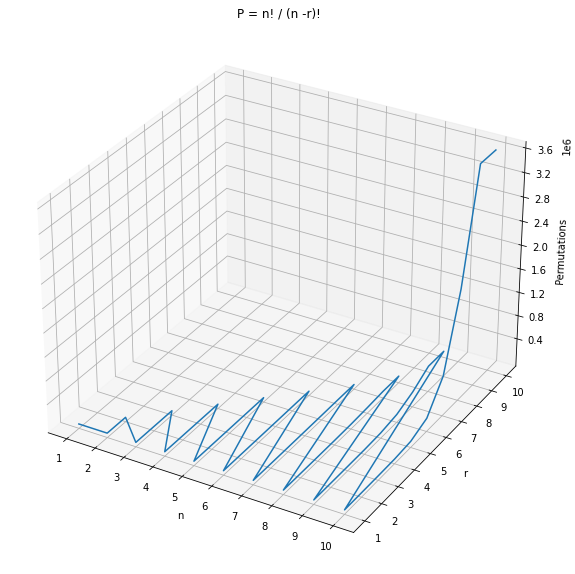

In [9]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
import numpy.ma as ma

def compute_permutation_size(A, r):
    n = len(A)
    return int(factorial(n) / factorial(n -r))

P = []
A = []
B = []

for a in range(1, 10 +1):
    for b in range(1, a +1):
        A += [a]
        B += [b]
        P += [compute_permutation_size(range(a), b)]

A = np.array(A, dtype=float)
B = np.array(B, dtype=float)
P = np.array(P, dtype=float)

# Mask to remove unwanted points
PERMUTATIONS_LIMIT = 1e3
Pm = ma.masked_greater_equal(P, PERMUTATIONS_LIMIT, copy=True)
Am = ma.MaskedArray(A, mask=Pm.mask)
Bm = ma.MaskedArray(B, mask=Pm.mask)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
plt.title("P = n! / (n -r)!")
ax.set_xlabel("n")
ax.set_ylabel("r")
ax.set_zlabel("Permutations")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.zaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(Am, Bm, Pm)
# ax.azim = 220   # z rotation (default=270)
# ax.elev = 2     # x rotation (default=0)
# ax.dist = 10    # zoom (define perspective)
# ax.set_zlim(top=PERMUTATIONS_LIMIT)
plt.show()

Fazendo uma otimização para cada chunk:

In [20]:
def compute_permutation_size(A, r):
    n = len(A)
    return int(factorial(n) / factorial(n -r))

def func_data(arr):
    return np.abs(np.array(arr).reshape((-1, len(B))) - B)

def func_chunk(chunk):
    local_costs = np.apply_along_axis(func_data, 1, chunk).reshape((-1, len(B)))
    total_cost = local_costs.sum(axis=1)
    index = total_cost.argmin()
    return chunk[index], total_cost[index]

def chunker(iterator, size):
    iterator = iter(iterator)
    while chunk := list(itertools.islice(iterator, size)):
        yield chunk

def parallel_process(f, data):
    pool = multiprocessing.Pool(cpu_threads)
    for result in pool.imap_unordered(f, data):
        yield result
    pool.close()
    pool.join()
    
def optimize(chunksize):
    results = {'costs': [], 'combs': []}
    
    chunks = chunker(permutations, chunksize)
    for result in parallel_process(func_chunk, chunks):
        comb, cost = result
        results['costs'] += [cost]
        results['combs'] += [comb]
    
    index = results['costs'].index(min(results['costs']))
    results['costs'] = results['costs'][index]
    results['combs'] = results['combs'][index]
    
    return results


A = np.array(range(5))
B = np.array(range(3)) + 0.2
print('A:', A, '\nB:', B, '\n' + '-' * 80);

permutations = itertools.permutations(A, len(B))
permutations_size = compute_permutation_size(A, len(B))
cpu_threads = multiprocessing.cpu_count()
chunksize = permutations_size // cpu_threads
total_thrads = chunksize // cpu_threads

print("Permutations size:", permutations_size)
print("CPU Threads:", cpu_threads)
print("Chunk size:", chunksize)
print("Total Threads:", total_thrads)

elapsed_time = -time.time()
permutations = itertools.permutations(A, len(B))
results = optimize(chunksize)
elapsed_time += time.time()

print("Elapsed Time:", elapsed_time, 's')
print("Results:\n", results)

A: [0 1 2 3 4 5 6 7 8 9] 
B: [0.2 1.2 2.2 3.2 4.2 5.2 6.2 7.2 8.2 9.2] 
--------------------------------------------------------------------------------
Permutations size: 3628800
CPU Threads: 16
Chunk size: 226800
Total Threads: 14175
Elapsed Time: 3.6790781021118164 s
Results:
 {'costs': 1.9999999999999996, 'combs': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)}


Comparando chunksizes:

A: [0 1 2 3 4 5 6 7 8 9] 
B: [0.2 1.2 2.2 3.2 4.2 5.2 6.2 7.2 8.2 9.2] 
--------------------------------------------------------------------------------
Chunksize: 16, Elapsed Time: 24.54554772377014
Chunksize: 32, Elapsed Time: 12.469361543655396
Chunksize: 64, Elapsed Time: 7.437630653381348
Chunksize: 128, Elapsed Time: 4.757745981216431
Chunksize: 256, Elapsed Time: 3.7492239475250244
Chunksize: 512, Elapsed Time: 3.4163198471069336
Chunksize: 1024, Elapsed Time: 3.0780348777770996
Chunksize: 2048, Elapsed Time: 2.859876871109009
Chunksize: 4096, Elapsed Time: 2.8601648807525635
Chunksize: 8192, Elapsed Time: 2.8200619220733643
Chunksize: 16384, Elapsed Time: 2.805985450744629
Chunksize: 32768, Elapsed Time: 2.8813183307647705
Chunksize: 65536, Elapsed Time: 3.008202075958252
Chunksize: 131072, Elapsed Time: 3.2362468242645264
Chunksize: 262144, Elapsed Time: 3.713390350341797
Chunksize: 524288, Elapsed Time: 4.826794862747192
Done!


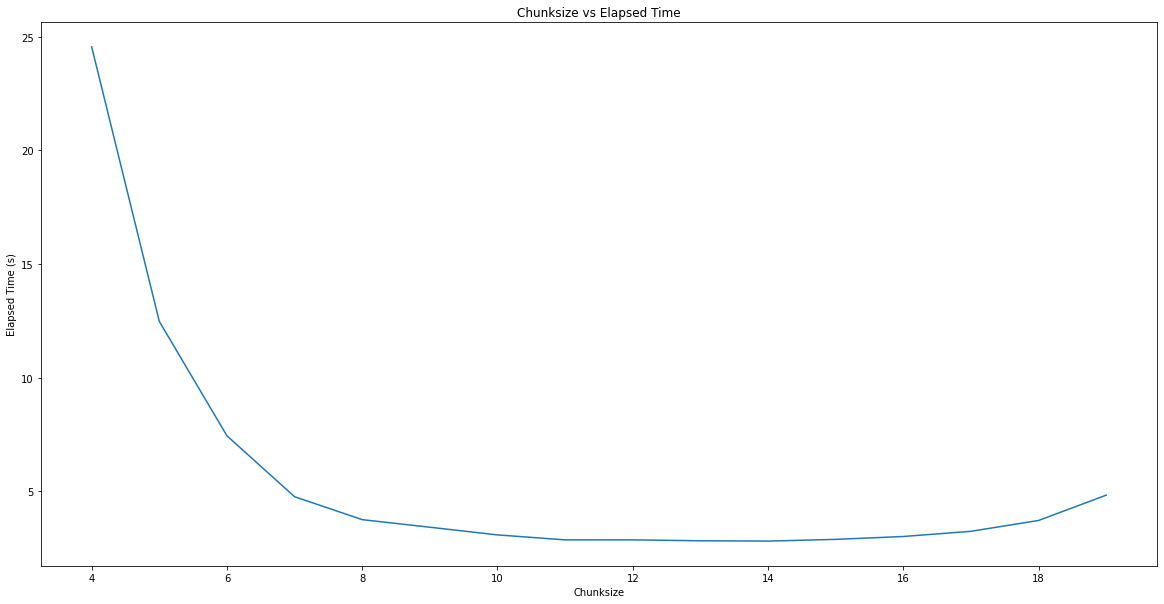

In [71]:
A = np.array(range(10))
B = np.array(range(10)) + 0.2
print('A:', A, '\nB:', B, '\n' + '-' * 80);

elapsed_times = []
chunksizes_power = np.array(list(range(16))) + 4
chunksizes = 2**chunksizes_power
for chunksize in chunksizes:
    print("Chunksize:", chunksize, end=', ')
    elapsed_time = -time.time()
    permutations = itertools.permutations(A, len(B))
    results = optimize(chunksize)
    elapsed_time += time.time()

    elapsed_times += [elapsed_time]
    
    print("Elapsed Time:", elapsed_time)

elapsed_times = np.array(elapsed_times)
print("Done!")

plt.figure(figsize=(20,10))
plt.title("Chunksize vs Elapsed Time")
plt.ylabel("Elapsed Time (s)")
plt.xlabel("Chunksize")
plt.plot(chunksizes_power, elapsed_times)
plt.show()

Variando o tamanho do dado

In [28]:
elapsed_time_array = []
permutations_size_array = []
cpu_threads_array = []
chunksize_array = []
total_threads_array = []

data_length_array = list(range(6, 12))

for data_length in data_length_array:
    global A, B, permutations
    
    print("Length:", data_length, end='...')
    
    A = np.array(range(data_length))
    B = np.array(range(data_length)) + 0.2

    elapsed_time = -time.time()
    
    permutations = itertools.permutations(A, len(B))
    permutations_size = compute_permutation_size(A, len(B))
    cpu_threads = multiprocessing.cpu_count()
    chunksize = permutations_size // cpu_threads
    total_threads = chunksize // cpu_threads
    
    results = optimize(chunksize)
    elapsed_time += time.time()

    elapsed_time_array += [elapsed_time]
    permutations_size_array += [permutations_size]
    cpu_threads_array += [cpu_threads]
    chunksize_array += [chunksize]
    total_threads_array += [total_threads]
    
    print("Ok!")
    

import pandas as pd
df = pd.DataFrame()
df['Elapsed Time'] = np.array(elapsed_time_array)
df['Data length'] = np.array(data_length_array)
df['Permutations Length'] = np.array(permutations_size_array)
# df['CPU Threads'] = np.array(cpu_threads_array)
df['Chunk Size'] = np.array(chunksize_array)
df['Processes Executed'] = np.array(total_threads_array)

df

Length: 6...Ok!
Length: 7...Ok!
Length: 8...Ok!
Length: 9...Ok!
Length: 10...Ok!
Length: 11...Ok!


,Elapsed Time,Data length,Permutations Length,Chunk Size,Processes Executed
0,0.085777,6,720,45,2
1,0.076440,7,5040,315,19
2,0.123428,8,40320,2520,157
3,0.705706,9,362880,22680,1417
4,3.577390,10,3628800,226800,14175
5,41.922758,11,39916800,2494800,155925


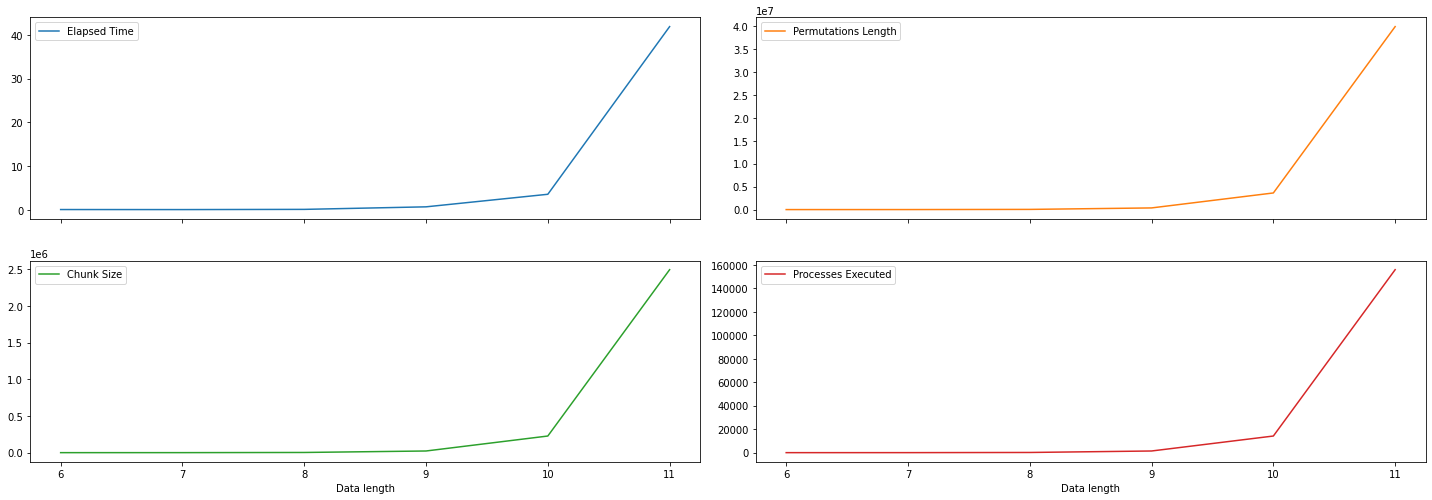

In [34]:
df.plot(x='Data length', figsize=(20,10), subplots=True, layout=(3, 2))

plt.tight_layout()
plt.show()

### Trabalhando com array de bounding boxes

In [38]:
from math import factorial
import itertools
import multiprocessing

def compute_permutation_size(A, r):
    n = len(A)
    return int(factorial(n) / factorial(n -r))

def func_data(arr):
    global B, lenB
    return np.abs(np.array(arr).reshape((-1, lenB)) - B)

def func_chunk(chunk):
    global B, lenB
    print('func_chunk')
    print(chunk)
    local_costs = np.apply_along_axis(func_data, 1, chunk).reshape((-1, lenB))
    total_cost = local_costs.sum(axis=1)
    index = total_cost.argmin()
    return chunk[index], total_cost[index]

def chunker(iterator, size):
    iterator = iter(iterator)
    while chunk := list(itertools.islice(iterator, size)):
        yield chunk

def parallel_process(f, data):
    pool = multiprocessing.Pool(cpu_threads)
    for result in pool.imap_unordered(f, data):
        yield result
    pool.close()
    pool.join()
    
def optimize():
    global permutations, chunksize, A, B, lenB
    
    results = {'costs': [], 'combs': []}
    
    chunks = chunker(permutations, chunksize)
    for result in parallel_process(func_chunk, chunks):
        comb, cost = result
        results['costs'] += [cost]
        results['combs'] += [comb]
    
    index = results['costs'].index(min(results['costs']))
    results['costs'] = results['costs'][index]
    results['combs'] = results['combs'][index]
    
    return results

lenB = len(B)
permutations_size = compute_permutation_size(A, lenB)
if (permutations_size <= 3628800):
    print("Permutations size:", permutations_size)
    
    cpu_threads = multiprocessing.cpu_count()
    print("CPU Threads:", cpu_threads)
    
    chunksize = permutations_size // cpu_threads
    print("Chunk size:", chunksize)
    
    total_thrads = chunksize // cpu_threads
    print("Total Threads:", total_thrads)

    elapsed_time = -time.time()
    permutations = itertools.permutations(A, lenB)
    results = optimize()
    elapsed_time += time.time()

    print("Elapsed Time:", elapsed_time, 's')
    print("Results:\n", results)

Permutations size: 12
CPU Threads: 16
Chunk size: 0
Total Threads: 0


ValueError: min() arg is an empty sequence